<a href="https://colab.research.google.com/github/shamsakhoja7-max/msba-portfolio-shamsakhoja/blob/main/TRUSOURCE_SCORING_DATA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Imports
import os
import numpy as np
import pandas as pd

In [2]:
from google.colab import drive
drive.mount('/content/drive')

telco_df2 = pd.read_excel('/content/drive/MyDrive/Class - PA/churn_df_data_2 (1).xlsx')

Mounted at /content/drive


Step 1: Partition our Data and Pre-processing.

In [3]:
### For classification problems, first determine the classes of your response variable
print(telco_df2["left_flag"].dtype)
print(telco_df2["left_flag"].unique())

object
['No' 'Yes']


In [4]:
Y = (telco_df2["left_flag"] == "Yes") # returns True for rows where response == 1 and False otherwise then .astype(int) converts True→1 and False→0, so the “positive” label becomes 1

X = telco_df2.drop(columns=["left_flag"])


In [5]:
Y.unique() #check if this was done

array([False,  True])

In [6]:
X.columns #check if this was done

Index(['has_dependents', 'tenure_mo', 'home_phone', 'multi_line',
       'contract_term', 'e_bill_opt_in', 'pay_method', 'monthly_fee',
       'total_billed', 'gender', 'age_years', 'is_married', 'recent_offer',
       'avg_long_dist_fee', 'internet_tech', 'avg_gb_download',
       'unlimited_data_opt', 'extra_data_fees_total', 'long_dist_fees_total',
       'num_add_ons', 'has_add_on', 'has_streaming', 'is_referrer',
       'received_refund', 'overage_ratio', 'unexpected_cost_burden'],
      dtype='object')

In [7]:
from sklearn.model_selection import train_test_split

# Split into train/test sets
X_train, X_test, y_train, Y_test = train_test_split(
    X, Y,
    test_size=0.3,     # 30% test, 70% train
    random_state=99,   # reproducibility
    shuffle=True       # shuffle before splitting
)

# Check shapes
X_train.shape, X_test.shape

((3945, 26), (1691, 26))

In [8]:
!pip install catboost


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 9.0 MB/s eta 0:00:00


Trying another catboost

In [9]:
print(type(y_train))
print(getattr(y_train, "shape", None))


<class 'pandas.core.series.Series'>
(3945,)


In [10]:
from sklearn.model_selection import StratifiedKFold

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)


In [11]:
from catboost import CatBoostClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

cat_cols = ['has_dependents',
 'home_phone',
 'multi_line',
 'contract_term',
 'e_bill_opt_in',
 'pay_method',
 'gender',
 'is_married',
 'recent_offer',
 'internet_tech',
 'unlimited_data_opt']  # categorical column names in your X DataFrame

cat_pipe = Pipeline([
    ("model", CatBoostClassifier(
        loss_function="Logloss",
        eval_metric="AUC",
        random_seed=99,
        verbose=0,                # keeps output quiet for students
        allow_writing_files=False # avoids CatBoost creating extra files
    ))
])

param_grid = {
    "model__depth": [4, 6, 8],
    "model__learning_rate": [0.01, 0.03],
    "model__iterations": [400, 800],
    "model__l2_leaf_reg": [1, 3, 10],


}

cat_cv = GridSearchCV(
    estimator=cat_pipe,
    param_grid=param_grid,
    cv=cv,
    scoring="roc_auc",
    n_jobs=-1,
    refit=True,
    return_train_score=True # checking training score
)

# This is the key line: pass cat_features at FIT time
cat_cv.fit(X_train, y_train, model__cat_features=cat_cols)

best_model = cat_cv.best_estimator_
print(cat_cv.best_params_)


{'model__depth': 4, 'model__iterations': 400, 'model__l2_leaf_reg': 1, 'model__learning_rate': 0.03}


In [12]:
from sklearn.metrics import roc_auc_score

best_model = cat_cv.best_estimator_   # pipeline with ("model", CatBoostClassifier)


#printing both AUC (Training and Validation to check the AUC stability)
cv_results = pd.DataFrame(cat_cv.cv_results_)
best_idx = cat_cv.best_index_

# ✅ Training + Validation AUC (from CV)
print(f"Training AUC (CV avg):   {cv_results.loc[best_idx, 'mean_train_score']:.3f}")
print(f"Validation AUC (CV avg): {cv_results.loc[best_idx, 'mean_test_score']:.3f}")


y_test_proba = best_model.predict_proba(X_test)[:, 1]

auc = roc_auc_score(Y_test, y_test_proba)
print(f"CatBoost (tuned) Test AUC: {auc:.3f}")


Training AUC (CV avg):   0.890
Validation AUC (CV avg): 0.845
CatBoost (tuned) Test AUC: 0.851


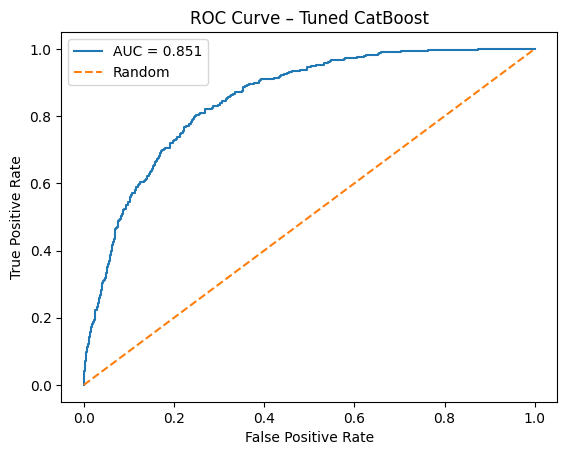

In [13]:
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt

fpr, tpr, _ = roc_curve(Y_test, y_test_proba)

plt.figure()
plt.plot(fpr, tpr, label=f"AUC = {auc:.3f}")
plt.plot([0, 1], [0, 1], linestyle="--", label="Random")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve – Tuned CatBoost")
plt.legend()
plt.show()


Test PR-AUC: 0.6713


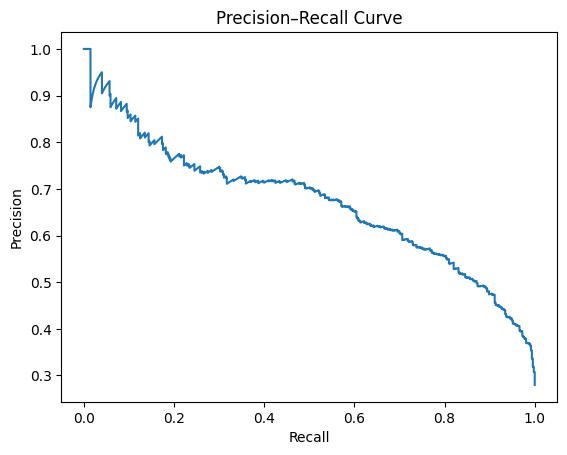

In [14]:
#precision

from sklearn.metrics import average_precision_score

pr_auc = average_precision_score(Y_test, y_test_proba)
print("Test PR-AUC:", round(pr_auc, 4))

from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt

precision, recall, _ = precision_recall_curve(Y_test, y_test_proba)

plt.plot(recall, precision)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall Curve")
plt.show()

#Scoreing the hold out set

In [16]:
# Read the data

holdout = pd.read_excel('/content/drive/MyDrive/Class - PA/HOLD_OUT_DATA_CHURN.xlsx')

In [17]:
#separating the response variable

Y_hold = (holdout["left_flag"] == "Yes")
X_hold = holdout.drop(columns=["left_flag"])

In [18]:
#Make predictions
Y_test_proba_hold = best_model.predict_proba(X_hold)[:, 1]

Trained model (best_model) looks at each customer's info and says "I think there's a 73% chance this person will leave" or "12% chance this person will leave", etc.
The [:, 1] part just grabs the probability of "Yes, they'll leave."

In [22]:
# check prediction accuracy
auc_hold = roc_auc_score(Y_hold, Y_test_proba_hold)
print(f"CatBoost (tuned) Holdout AUC: {auc_hold:.3f}")

CatBoost (tuned) Holdout AUC: 0.857


In [23]:
from sklearn.metrics import precision_recall_curve, auc

# Calculate precision and recall at different thresholds
precision, recall, thresholds = precision_recall_curve(Y_hold, Y_test_proba_hold)

# Calculate AUC-PR
auc_pr = auc(recall, precision)

print(f"AUC-PR: {auc_pr:.3f}")

AUC-PR: 0.679


In [24]:
#saving predictions
holdout["predicted_prob"] = Y_test_proba_hold
holdout.to_csv("churn_holdout_scored_for_turnin.csv", index=False)